In [1]:
#!pip install pandas numpy scikit-learn matplotlib seaborn joblib torch transformers datasets tqdm

## Sentiment Analysis Model Training
### This notebook covers:
 1. Data loading and preprocessing
 2. Baseline model (TF-IDF + Logistic Regression)
 3. Transformer model (DistilBERT) fine-tuning
 4. Model evaluation and saving

## 1. Setup and Data Loading

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import warnings

In [5]:
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [6]:
# Load the dataset
df = pd.read_csv(r"C:\Users\yarra\OP\sentiment-analysis-project\data\amazon_reviews.csv")

In [7]:
# Display basic info
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 2. Data Preprocessing

In [9]:
# Create binary sentiment labels
df['sentiment'] = df['Score'].apply(lambda x: 'positive' if x > 3 else 'negative')

In [10]:
# Check class distribution
print("Class distribution:")
print(df['sentiment'].value_counts(normalize=True))

Class distribution:
sentiment
positive    0.780674
negative    0.219326
Name: proportion, dtype: float64


In [11]:
# Subsample to 200k balanced reviews
sample_size = 200000
df_positive = df[df['sentiment'] == 'positive'].sample(n=sample_size//2, random_state=42)
df_negative = df[df['sentiment'] == 'negative'].sample(n=sample_size//2, random_state=42)
df_balanced = pd.concat([df_positive, df_negative])

In [12]:
# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [13]:
# Train-test split
train_df, test_df = train_test_split(
    df_balanced, 
    test_size=0.2, 
    random_state=42,
    stratify=df_balanced['sentiment']
)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 160000
Test size: 40000



## 3. Baseline Model (TF-IDF + Logistic Regression)



In [15]:
# Initialize and fit TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=5,
    max_df=0.7
)

X_train = vectorizer.fit_transform(train_df['Text'])
X_test = vectorizer.transform(test_df['Text'])

In [16]:
# Train logistic regression model
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    C=0.1,
    solver='saga'
)

lr_model.fit(X_train, train_df['sentiment'])

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='saga')

In [17]:
# Evaluate baseline model
y_pred = lr_model.predict(X_test)
y_true = test_df['sentiment']

print("Classification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.85      0.85     20000
    positive       0.85      0.84      0.85     20000

    accuracy                           0.85     40000
   macro avg       0.85      0.85      0.85     40000
weighted avg       0.85      0.85      0.85     40000



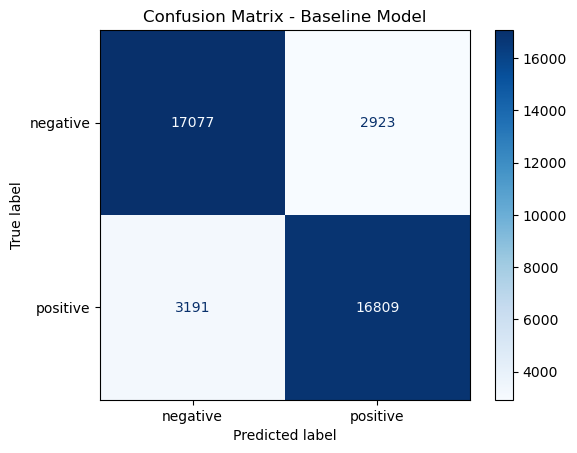

In [18]:
# Confusion matrix visualization
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=lr_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Baseline Model')
plt.show()

In [19]:
# Save baseline model artifacts
joblib.dump(lr_model, r'C:\Users\yarra\OP\sentiment-analysis-project\models\logreg_model.pkl')
joblib.dump(vectorizer, r'C:\Users\yarra\OP\sentiment-analysis-project\models\tfidf_vectorizer.pkl')

['C:\\Users\\yarra\\OP\\sentiment-analysis-project\\models\\tfidf_vectorizer.pkl']

## 4. Transformer Model (DistilBERT)

In [21]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
from tqdm import tqdm


In [23]:
# Load and clean
df = pd.read_csv("amazon_reviews.csv")  # Replace with your actual file name
df = df.dropna(subset=["Score", "Text"])
df = df[df["Score"] != 3]  # remove neutral
df["label"] = df["Score"].apply(lambda x: 1 if x >= 4 else 0)

# Balanced sample (10k per class)
min_class = min(10000, df.label.value_counts()[0], df.label.value_counts()[1])
df_pos = df[df.label == 1].sample(n=min_class, random_state=42)
df_neg = df[df.label == 0].sample(n=min_class, random_state=42)
df_balanced = pd.concat([df_pos, df_neg]).sample(frac=1).reset_index(drop=True)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced["Text"], df_balanced["label"], test_size=0.2, random_state=42
)


In [24]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)

In [25]:
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }
    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_labels.tolist())
val_dataset = ReviewDataset(val_encodings, val_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [26]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optim = AdamW(model.parameters(), lr=2e-5)
epochs = 1

model.train()
for epoch in range(epochs):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 0: 100%|██████████████████████████████████████████████████████████| 2000/2000 [59:19<00:00,  1.78s/it, loss=0.11]


## 5. Model Comparison

In [28]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ Precision: {p:.4f}")
print(f"✅ Recall: {r:.4f}")
print(f"✅ F1 Score: {f1:.4f}")

✅ Accuracy: 0.9125
✅ Precision: 0.9141
✅ Recall: 0.9125
✅ F1 Score: 0.9123



📊 Model Comparison:
                          Model  Accuracy  F1 Score
0  TF-IDF + Logistic Regression   0.84715  0.847143
1         Fine-tuned DistilBERT   0.91250  0.912329


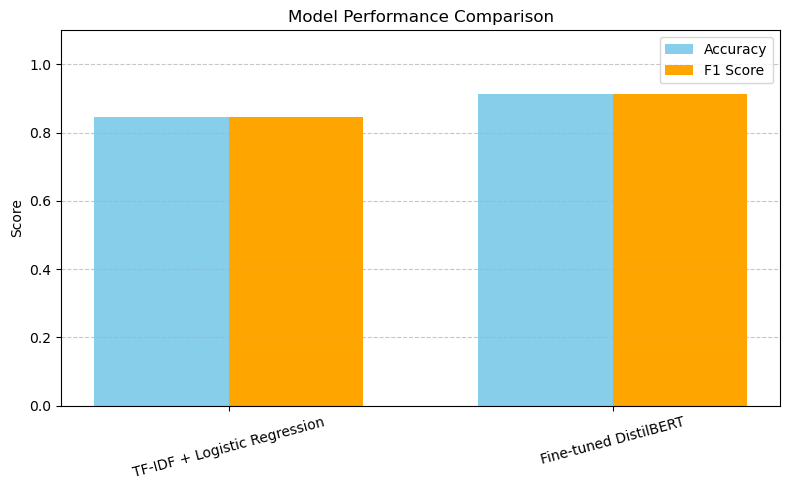

In [63]:
# ============
# 📊 Model Comparison
# ============

# Logistic Regression Results (TF-IDF)
lr_report = classification_report(y_true, y_pred, output_dict=True)
lr_accuracy = lr_report["accuracy"]
lr_f1 = lr_report["weighted avg"]["f1-score"]

# DistilBERT Results
bert_accuracy = acc  # already calculated above
bert_f1 = f1         # already calculated above

# Combine results
comparison_df = pd.DataFrame({
    "Model": ["TF-IDF + Logistic Regression", "Fine-tuned DistilBERT"],
    "Accuracy": [lr_accuracy, bert_accuracy],
    "F1 Score": [lr_f1, bert_f1]
})

print("\n📊 Model Comparison:")
print(comparison_df)

# 📉 Bar Plot for Visual Comparison
plt.figure(figsize=(8, 5))
bar_width = 0.35
x = np.arange(len(comparison_df["Model"]))

# Bars
plt.bar(x - bar_width/2, comparison_df["Accuracy"], width=bar_width, label="Accuracy", color="skyblue")
plt.bar(x + bar_width/2, comparison_df["F1 Score"], width=bar_width, label="F1 Score", color="orange")

# Labels & Styling
plt.xticks(x, comparison_df["Model"], rotation=15)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [59]:
# Save model weights
#torch.save(model.state_dict(), "distilbert_sentiment.pt")

# Save tokenizer separately (you can still use .pickle or .joblib for tokenizer if needed)
#import joblib
#joblib.dump(tokenizer, "tokenizer.joblib")

In [61]:
#import torch
#import pickle

# Save model weights
#torch.save(model.state_dict(), "distilbert_sentiment.pt")

# Save tokenizer path and model info using pickle
#model_bundle = {
    #"model_name": "distilbert-base-uncased",
    #"model_path": "distilbert_sentiment.pt"
#}

#with open("model_bundle.pkl", "wb") as f:
    #pickle.dump(model_bundle, f)
